# Using ML to Predict an Spotify's "New Music Friday" Playlist
### This notebook is designed to predict which new tracks released to Spotify will be added to its "New Music Friday" Playlist based on the characteristics of recently released tracks and the playlist.

#### This playlist is manually curated and is a major deal in enabling artists to breakthrough in the music industry. Noteable discoveries from this playlist include Billie Eilish, Lizzo, and DaBaby! For more information see this link https://www.forbes.com/sites/monicamercuri/2020/02/21/spotify-unveils-global-rebrand-of-new-music-friday-playlist/#5d3320826360

### This notebook will be divided into the following sections
##### 1. Data Prep: Includes pulling data using Spotify's API and transforming into a format to deliver optimal model results
##### 2. Exploratory Analysis & Data Cleanup: Analyze data to identify trends, develop hypothesis, and incorporate learning to model
##### 3. Train & Test Models: Test various models and select optimal model
##### 4. Deploy model


###### By Mike Golodner for General Assermbly DAT Final Project 

### 1. Data Prep: 
###### 1. Identify New Music Friday Playlist
###### 2. Download all track ids for Current New Music Friday Playlist
###### 3. Download all new tracks ids for tracks added between min and max release date of songs in New Music Friday
###### 4. Check to ensure all track ids in step 2 are included in step 3
###### 5. Dowlnload detailed audio information for all track ids
###### 6. Download popularity of the artist and album assocaited with tracks
###### 7. Create a consoldiated dataset with all track details and a binary flag for whether track was included in playlist

In [251]:
# Admin: import necessary libraries. 
# Note spotipy is a python library designed for Spotify Web API. https://spotipy.readthedocs.io/en/2.9.0/#api-reference

import pandas as pd
import numpy as npb
import seaborn as sns
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt

In [253]:
# 1. Identify New Music Friday Playlist (which user mgolodner follows)

# Define user, scope, and tokens for API authentication.
user= 'mgolodner'
scope = 'user-top-read'
token = util.prompt_for_user_token(user,
                                   scope,
                                   client_id='c3c51465bc4041c69087875562cf76cc',
                                   client_secret='36fae5327bcf41568801191342a8b8cf',
                                   redirect_uri='http://localhost/')

# API call to return  list of user's Playlists
sp = spotipy.Spotify(auth=token)
user_playlists = sp.user_playlists(user)

# Loop through user_playlists to identify New Music Friday ID
for x in user_playlists['items']:
    if x['name'] == 'New Music Friday':
        new_music_id = x['id']
        print (x['id'])


37i9dQZF1DX4JAvHpjipBk


In [254]:
# 2. Download all track ids for Current New Music Friday Playlist

# API call to return tracks on the New Music Friday Playlist

playlist_tracks  = sp.playlist_tracks(new_music_id)

# Loop through tracks put key details in list of dictionaries.

nm_tracks=[]

for track in playlist_tracks['items']:
    songs ={'track_id': track['track']['id'] , 
             'track_name': track['track']['name'],
             'artist_id': track['track']['artists'][0]['id'],
             'artist_name': track['track']['artists'][0]['name'],
             'album_id': track['track']['album']['id'],
             'album_name': track['track']['album']['name'],
             'album_type': track['track']['album']['album_type'],
             'duration_ms': track['track']['duration_ms'],
             'popularity': track['track']['popularity'],
             'release_date': track['track']['album']['release_date']
            }
    nm_tracks.append(songs)
    
# Convert to pandas dataframe
df_playlist_tracks = pd.DataFrame(nm_tracks)
df_playlist_tracks.index.name = 'track_oder'

In [ ]:
# Save data in csv for future use

location = r'C:\Users\mgolo\Documents\ga_repo\Homework\Unit4\MG_SUBMISSION\api_data\df_playlist_tracks.csv'

df_playlist_tracks.to_csv (location,index = True, header=True)


In [ ]:
# 3. Download all new tracks ids for tracks added between min and max release date of songs in New Music Friday

min_dt = min(df_playlist_tracks['release_date'])
max_dt = max(df_playlist_tracks['release_date'])


df_playlist_tracks.sort_values(by ='release_date')
# Min = 3/16/20  ; max: 3/20/20 ; Only one value 

# API call to return recently release albums on Spotyify (limit of 50 values per call)
# Note1: No API call exists to pull recent tracks, so will need to pull recent albums and pull tracks from albums
# Note2: requires reauthenticating with new scope to run this call

# user= 'mgolodner'
scope = 'user-library-read'
token = util.prompt_for_user_token(user,
                                   scope,
                                   client_id='c3c51465bc4041c69087875562cf76cc',
                                   client_secret='36fae5327bcf41568801191342a8b8cf',
                                   redirect_uri='http://localhost/')

sp = spotipy.Spotify(auth=token)

# Loop through call with 4 offsets to see recent 850 albums only add albums between 3/16 and 3/20

new_album = []
offsets = [0,50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800]

for sets in offsets:
    new_release = sp.new_releases(limit=50,offset=sets)
    
    for album in new_release['albums']['items']:
        if  '2020-03-16' <= album['release_date'] <= '2020-03-20':
            add = {'release_date' : album['release_date'],
                   'name' : album['name'],
                   'id': album['id']
                  }                                        
            new_album.append(add)
        else:
            continue         
            
# Convert to dataframe

df_new_album = pd.DataFrame(new_album)
#Returns 33 rows

# For each of these albums pull details of underlying tracks

new_tracks = []
album_ids = df_new_album['id'].tolist()

# Commented out details do not exist in this api call

for ids in album_ids:
    album_tracks = sp.album_tracks(ids)
    
    for item in album_tracks['items']:
        songs ={ 
                'track_id': item['id'] , 
                 'track_name': item['name'],
                 'artist_id': item['artists'][0]['id'],
                 'artist_name': item['artists'][0]['name'],
                 'album_id': ids,
#                  'album_name': item['album']['name'],
#                  'album_type': item['album']['album_type'],
                 'duration_ms': item['duration_ms'],
#                  'popularity': item['popularity'],
#                  'release_date': item['album']['release_date']
                }
        new_tracks.append(songs) 

# Convert to dataframe
df_new_tracks = pd.DataFrame(new_tracks)
# returns 130 songs for 33 albums


In [ ]:
# 4. Check to ensure all track ids in step 2 are included in step 3

# df_join = df_playlist_tracks.merge(df_new_tracks, on='track_id',how='left')
# df_join[df_join['track_name_y'].isnull()==True].shape

# 23 have matches. Issue the new_releases call only includes 'featured albums'. 
# Rerunning to pull tracks from the 73 missing

album_id_2 = df_join[df_join['track_name_y'].isnull()==True]['album_id_x'].to_list()

for ids in album_id_2:
    album_tracks = sp.album_tracks(ids)
    
    for item in album_tracks['items']:
        songs ={ 
                'track_id': item['id'] , 
                 'track_name': item['name'],
                 'artist_id': item['artists'][0]['id'],
                 'artist_name': item['artists'][0]['name'],
                 'album_id': ids,
#                  'album_name': item['album']['name'],
#                  'album_type': item['album']['album_type'],
                 'duration_ms': item['duration_ms'],
#                  'popularity': item['popularity'],
#                  'release_date': item['album']['release_date']
                }
        new_tracks.append(songs) 

df_new_tracks_2 = pd.DataFrame(new_tracks)
# This now returns 293 tracks from 107 albums

# Rerun check
df_join = df_playlist_tracks.merge(df_new_tracks_2, on='track_id',how='left')
df_join[df_join['track_name_y'].isnull()==True]

# This now returns track details for all tracks assocaited with albums in "New Music Friday" and from "Recently Featured Albums"

In [ ]:
# Save data in csv for future use

location = r'C:\Users\mgolo\Documents\ga_repo\Homework\Unit4\MG_SUBMISSION\api_data\df_new_tracks.csv'

df_new_tracks_2.to_csv (location,index = True, header=True)


In [ ]:
# 5a. Pull detailed audio information for all track ids (audio info such as tempo, loudness)

# Create List of unique track id's to use for pulling associated track details (i.e. tempo, loudness, etc.)

track_ids = df_new_tracks_2['track_id'].unique().tolist()

# Split list of 293 into batches <50 due to API Requirements
track_ids_a = track_ids[0:50] 
track_ids_b = track_ids[50:100]
track_ids_c = track_ids[100:150]
track_ids_d = track_ids[150:200]
track_ids_e = track_ids[200:250]
track_ids_f = track_ids[250:]
# len(track_ids) == (len(track_ids_a) +len(track_ids_b) + len(track_ids_c) + len(track_ids_d)+len(track_ids_e)+len(track_ids_f))

# Download tack details for the tracks in the list created in prior cell.

user= 'mgolodner'
scope = 'user-top-read'
token = util.prompt_for_user_token(user,
                                   scope,
                                   client_id='c3c51465bc4041c69087875562cf76cc',
                                   client_secret='36fae5327bcf41568801191342a8b8cf',
                                   redirect_uri='http://localhost/')

# Loop through tracks put key details in list of dictionaries.

sp = spotipy.Spotify(auth=token)
track_details = []

features = sp.audio_features(tracks= track_ids_a)
for x in features: 
    if x:
        track_details.append(x)

features = sp.audio_features(tracks= track_ids_b)
for x in features: 
    if x:
        track_details.append(x)
    
features = sp.audio_features(tracks= track_ids_c)
for x in features: 
    if x:
        track_details.append(x)
    
features = sp.audio_features(tracks= track_ids_d)
for x in features: 
    if x:
        track_details.append(x)
    
features = sp.audio_features(tracks= track_ids_e)
for x in features: 
    if x:
        track_details.append(x)
    
features = sp.audio_features(tracks= track_ids_f)
for x in features: 
    track_details.append(x)
    
# Convert to pandas dataframe
df_track_details = pd.DataFrame(track_details)


In [ ]:
# 5b. Pull detailed audio information for all track ids (track info such as popularity artist)

# test = sp.tracks(tracks= ['6Hj9jySrnFppAI0sEMCZpJ','4ek3pPdfvIbPxynmlisI0k'], market=None)

track_details = []

features = sp.tracks(tracks= track_ids_a)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)

features = sp.tracks(tracks= track_ids_b)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)
    
features = sp.tracks(tracks= track_ids_c)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)
    
features = sp.tracks(tracks= track_ids_d)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)
    
features = sp.tracks(tracks= track_ids_e)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)
    
features = sp.tracks(tracks= track_ids_f)['tracks']
for track in features: 
    x ={'track_id': track['id'] ,
             'track_name': track['name'],
             'artist_id': track['artists'][0]['id'],
             'artist_name': track['artists'][0]['name'],
             'album_id': track['album']['id'],
             'album_name': track['album']['name'],
             'album_type': track['album']['album_type'],
             'duration_ms': track['duration_ms'],
             'popularity': track['popularity'],
             'release_date': track['album']['release_date']} 
    track_details.append(x)
    
# Convert to pandas dataframe
df_track_details_v2 = pd.DataFrame(track_details)


In [170]:
# 6A. Download popularity of the artist assocaited with tracks


# Pull unique list of artist ids. Split into chunks of 50 due to API restriction
artists = df_model['artist_id'].unique().tolist()
art_list_a = artists[0:50]
art_list_b = artists[50:100]
art_list_c = artists[100:]


# Reauthenticate API
user= 'mgolodner'
scope = 'user-top-read'
token = util.prompt_for_user_token(user,
                                   scope,
                                   client_id='c3c51465bc4041c69087875562cf76cc',
                                   client_secret='36fae5327bcf41568801191342a8b8cf',
                                   redirect_uri='http://localhost/')

# Loop through API call to return details about a list of artists; pull out the artist popularity
sp = spotipy.Spotify(auth=token)
art_pop_list =[]

artist_detail = sp.artists(art_list_a)
for art in artist_detail['artists']:
    pop = {'artist_id' : art['id'],
            'artist_popularity' : art['popularity']}
    art_pop_list.append(pop)

artist_detail = sp.artists(art_list_b)
for art in artist_detail['artists']:
    pop = {'artist_id' : art['id'],
            'artist_popularity' : art['popularity']}
    art_pop_list.append(pop)
    
artist_detail = sp.artists(art_list_c)
for art in artist_detail['artists']:
    pop = {'artist_id' : art['id'],
            'artist_popularity' : art['popularity']}
    art_pop_list.append(pop)

# Convert to pandas dataframe
df_artist_details = pd.DataFrame(art_pop_list)

In [169]:
# 6B. Download popularity of the albums assocaited with tracks

# Pull unique list album ids. Split into chunks of 20 due to API restriction
albums = df_model['album_id'].unique().tolist()

alb_list_a = albums[0:20]
alb_list_b = albums[20:40]
alb_list_c = albums[40:60]
alb_list_d = albums[60:80]
alb_list_e = albums[80:100]
alb_list_f = albums[100:120]

user= 'mgolodner'
scope = 'user-top-read'
token = util.prompt_for_user_token(user,
                                   scope,
                                   client_id='c3c51465bc4041c69087875562cf76cc',
                                   client_secret='36fae5327bcf41568801191342a8b8cf',
                                   redirect_uri='http://localhost/')


# Loop through API call to return details about a list of albums; pull out the album popularity
sp = spotipy.Spotify(auth=token)
alb_pop_list =[]

album_detail = sp.albums(alb_list_a)

album_detail = sp.albums(alb_list_a)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)
    
album_detail = sp.albums(alb_list_b)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)
    
album_detail = sp.albums(alb_list_c)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)

album_detail = sp.albums(alb_list_d)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)    

album_detail = sp.albums(alb_list_e)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)    
    
album_detail = sp.albums(alb_list_f)
for alb in album_detail['albums']:
    pop = {'album_id' : alb['id'],
            'album_popularity' : alb['popularity']}
    alb_pop_list.append(pop)    

# Convert to pandas dataframe
df_album_details = pd.DataFrame(alb_pop_list)


In [ ]:
# 6. Create a consoldiated dataset with all track details and a binary flag for whether track was included in playlist

# Join datasets which will become X variables
df_model = df_track_details_v2.merge(df_track_details,left_on='track_id',right_on='id',how='left')
df_model = df_model.drop(['type','id', 'uri','track_href','analysis_url','duration_ms_y'], axis=1)
df_model = df_model.merge(df_artist_details,left_on='artist_id',right_on='artist_id',how='left')
df_model = df_model.merge(df_album_details,left_on='album_id',right_on='album_id',how='left')


# Create binary variable for whehter in New Music Friday Playlist (1=Yes, 0 = No). This will be the Y variable
df_model = df_model.merge(df_playlist_tracks[['track_id','track_name']],on='track_id',how='left')
df_model['playlist_flag'] = np.where(df_model_2['track_name_y'].isnull(), 0, 1)

# Clean up column names
df_model = df_model.drop('track_name_y',axis=1)
df_model = df_model.rename(columns={"track_name_x": "track_name","duration_ms_x" :"duration_ms" })

In [179]:
# Save data in csv for future use

location = r'C:\Users\mgolo\Documents\ga_repo\Homework\Unit4\MG_SUBMISSION\api_data\df_model_v2.csv'

df_model.to_csv (location,index = True, header=True)


In [255]:
df_model = pd.read_csv(r'C:\Users\mgolo\Documents\ga_repo\Homework\Unit4\MG_SUBMISSION\api_data\df_model_v2.csv')
df_model = df_model.drop('Unnamed: 0',axis=1)
df_model

,track_id,track_name,artist_id,artist_name,album_id,album_name,album_type,duration_ms,popularity,release_date,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,playlist_flag,artist_popularity,album_popularity
0,6b5P51m8xx2XA6U7sdNZ5E,Alone Again,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,250053,80,2020-03-20,...,0.0386,0.0499,0.121000,0.1750,0.0645,136.057,4.0,0,96,90
1,2K9Ovn1o2bTGqbsABGC6m3,Too Late,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,239973,79,2020-03-20,...,0.1060,0.0542,0.000241,0.6780,0.2300,120.008,4.0,1,96,90
2,6kWxIqQDsKFYCJGbU4AjCX,Hardest To Love,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,211400,79,2020-03-20,...,0.0670,0.0879,0.000165,0.1170,0.1030,83.679,4.0,0,96,90
3,4BGZF4oLbTL0pWm7C18pbv,Scared To Live,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,191306,79,2020-03-20,...,0.0692,0.1080,0.000000,0.0934,0.2210,87.983,4.0,1,96,90
4,3WlbeuhfRSqU7ylK2Ui5U7,Snowchild,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,247186,78,2020-03-20,...,0.1040,0.1600,0.000043,0.1220,0.3270,148.060,4.0,0,96,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,3COaKkTWnCXduzPjQMK2Tg,Energy,6M6XXCcO5gI68XpIlrUL3Z,Young T & Bugsey,3fs9Y3TQ3twby9Yc3b7uL8,Plead The 5th,album,194786,39,2020-03-20,...,0.1840,0.4260,0.000849,0.1390,0.5780,160.003,4.0,0,68,54
289,373ycqaRJ1koW4xpRnjDol,Plead The 5th,6M6XXCcO5gI68XpIlrUL3Z,Young T & Bugsey,3fs9Y3TQ3twby9Yc3b7uL8,Plead The 5th,album,174400,40,2020-03-20,...,0.1260,0.2310,0.026300,0.0968,0.4300,100.176,4.0,0,68,54
290,62PilcxFCGFsjNyG0GhqSk,Strike a Pose (feat. Aitch),6M6XXCcO5gI68XpIlrUL3Z,Young T & Bugsey,3fs9Y3TQ3twby9Yc3b7uL8,Plead The 5th,album,213226,36,2020-03-20,...,0.1110,0.0121,0.000018,0.1020,0.6020,140.153,5.0,0,68,54
291,57e2Ut4bs6u3mriHX6qkBj,Wife You,4bMNzAopkqYTwkBLwMKsF1,Childish Major,5OIXiKShyOmKIbzF6P8as7,Wife You,single,191459,43,2020-03-19,...,0.0444,0.1960,0.000002,0.1200,0.5140,102.000,4.0,1,57,36


### 2. Exploratory Analysis & Data Cleanup:

##### 1. Lookup distribution of tracks included and not included in playlist, and identify correlated variables
##### 2. Check for missing values and address if needed
##### 3. Review datatypes to identify ordinal varaibles
##### 4. Review unique values to identify ordinal variable

In [ ]:
#Exploratory Analysis & Data Cleanup

#1. Lookup distribution of tracks included and not included in playlist
#2. Check for missing values and address if needed
#3. Review datatypes to identify ordinal varaibles
#4. Review unique values to identify ordinal variables

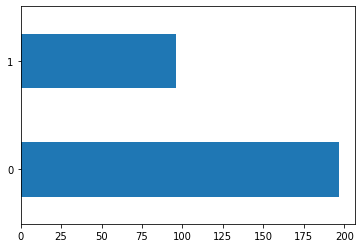

In [180]:
#1a. Lookup distribution of tracks included and not included in playlist

play_counts =pd.value_counts(df_model['playlist_flag'].values, sort=True)
play_counts.plot.barh();

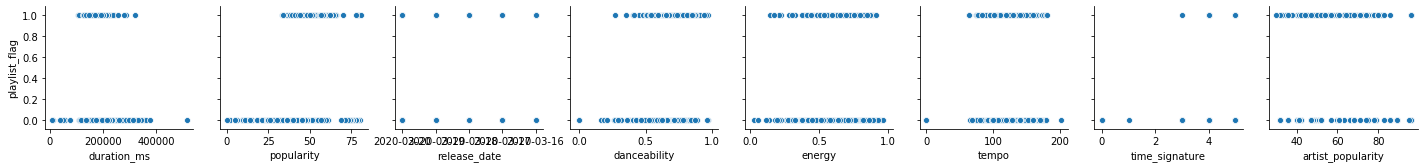

In [257]:
#1b run pairplot to identify trends

sns.pairplot(data=df_model,x_vars=['duration_ms', 'popularity', 'release_date',
       'danceability', 'energy', 'tempo','time_signature','artist_popularity'],y_vars=['playlist_flag']);

# While no clear trends. It seems there are some correlations with popularity, danceability, duration, and time signature.

In [258]:
# 2 Check for missing values and address if needed
df_model.isnull().sum()

#Result: There is 1 track with nulls from track_details (audio features such as tempo and loudnness). This track is also in the Playlist set.


track_id             0
track_name           0
artist_id            0
artist_name          0
album_id             0
album_name           0
album_type           0
duration_ms          0
popularity           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
playlist_flag        0
artist_popularity    0
album_popularity     0
dtype: int64

In [103]:
# 2 Check for missing values and address if needed

# Define variables to replace nulls with in dataset. Approach: Use mean for continuous variables and mode for ordinal.

dance_mean = df_model['danceability'].mean()
energy_mean = df_model['energy'].mean()
key_mode = df_model['key'].mode()[0]
loud_mean = df_model['loudness'].mean()
mode_mode = df_model['mode'].mode()[0]
speech_mean = df_model['speechiness'].mean()
acoustic_mean = df_model['acousticness'].mean()
instument_mean = df_model['instrumentalness'].mean()
liveness_mean = df_model['liveness'].mean()
valence_mean = df_model['valence'].mean()
tempo_mean = df_model['tempo'].mean()
time_mode = df_model['time_signature'].mode()[0]

# Fill nulls with mean/mode variables

df_model['danceability'].fillna(dance_mean, inplace=True)
df_model['energy'].fillna(energy_mean, inplace=True)
df_model['key'].fillna(key_mode, inplace=True)
df_model['loudness'].fillna(loud_mean, inplace=True)
df_model['mode'].fillna(mode_mode, inplace=True)
df_model['speechiness'].fillna(speech_mean, inplace=True)
df_model['acousticness'].fillna(acoustic_mean, inplace=True)
df_model['instrumentalness'].fillna(instument_mean, inplace=True)
df_model['liveness'].fillna(liveness_mean, inplace=True)
df_model['valence'].fillna(valence_mean, inplace=True)
df_model['tempo'].fillna(tempo_mean, inplace=True)
df_model['time_signature'].fillna(time_mode, inplace=True)

In [183]:
#3. Review datatypes to identify ordinal varaibles

df_model.dtypes

# fields to create dummy variables: album_type
# release date may need to be transformed (i.e. # of days since playlist release)
# track_id is the key
# Descriptive fields which can be removed for modeling:
# track_name,artist_id, artist_name, album_id, album_name

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
album_name            object
album_type            object
duration_ms            int64
popularity             int64
release_date          object
danceability         float64
energy               float64
key                  float64
loudness             float64
mode                 float64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature       float64
playlist_flag          int64
artist_popularity      int64
album_popularity       int64
dtype: object

In [184]:
#Transform release date to represent days on spotify before playlist is released
df_model['release_date'] = pd.to_datetime(df_model['release_date'])

playlist_release_dt = pd.to_datetime({'year':[2020], 'month':[3], 'day':[20]})
df_model['playlist_dt'] =  df_model.apply(lambda x: playlist_release_dt, axis=1)

df_model['days_on_spotify'] = (df_model['playlist_dt'] - df_model['release_date']).dt.days 
df_model.head(20)


,track_id,track_name,artist_id,artist_name,album_id,album_name,album_type,duration_ms,popularity,release_date,...,instrumentalness,liveness,valence,tempo,time_signature,playlist_flag,artist_popularity,album_popularity,playlist_dt,days_on_spotify
0,6b5P51m8xx2XA6U7sdNZ5E,Alone Again,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,250053,80,2020-03-20,...,0.121000,0.1750,0.0645,136.057,4.0,0,96,90,2020-03-20,0
1,2K9Ovn1o2bTGqbsABGC6m3,Too Late,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,239973,79,2020-03-20,...,0.000241,0.6780,0.2300,120.008,4.0,1,96,90,2020-03-20,0
2,6kWxIqQDsKFYCJGbU4AjCX,Hardest To Love,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,211400,79,2020-03-20,...,0.000165,0.1170,0.1030,83.679,4.0,0,96,90,2020-03-20,0
3,4BGZF4oLbTL0pWm7C18pbv,Scared To Live,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,191306,79,2020-03-20,...,0.000000,0.0934,0.2210,87.983,4.0,1,96,90,2020-03-20,0
4,3WlbeuhfRSqU7ylK2Ui5U7,Snowchild,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,247186,78,2020-03-20,...,0.000043,0.1220,0.3270,148.060,4.0,0,96,90,2020-03-20,0
5,1sOW4PuG5X3Ie3EXUhAopJ,Escape From LA,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,355960,78,2020-03-20,...,0.005380,0.2050,0.1610,143.273,4.0,0,96,90,2020-03-20,0
6,6bnF93Rx87YqUBLSgjiMU8,Heartless,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,198266,76,2020-03-20,...,0.000001,0.1690,0.2240,169.961,4.0,0,96,90,2020-03-20,0
7,3orEOtd8CPL8GFlpRpKuoE,Faith,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,283226,78,2020-03-20,...,0.049300,0.1460,0.1300,87.949,4.0,0,96,90,2020-03-20,0
8,0VjIjW4GlUZAMYd2vXMi3b,Blinding Lights,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,200040,76,2020-03-20,...,0.000209,0.0953,0.3470,171.021,4.0,0,96,90,2020-03-20,0
9,7szuecWAPwGoV1e5vGu8tl,In Your Eyes,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,4yP0hdKOZPNshxUOjY0cZj,After Hours,album,237520,81,2020-03-20,...,0.000072,0.0740,0.7200,100.033,4.0,1,96,90,2020-03-20,0


In [185]:
#4. Review unique values to identify ordinal variables

df_model.nunique()

# Variables to encode for: album_type, key, mode, time_signature
# release_date to stay continuous but be transformed

track_id             293
track_name           281
artist_id            102
artist_name          102
album_id             107
album_name           104
album_type             2
duration_ms          282
popularity            70
release_date           5
danceability         227
energy               229
key                   12
loudness             288
mode                   2
speechiness          245
acousticness         264
instrumentalness     177
liveness             195
valence              246
tempo                288
time_signature         5
playlist_flag          2
artist_popularity     49
album_popularity      38
playlist_dt            1
days_on_spotify        5
dtype: int64

### 3. Train & Test Models

##### 1. Create Training and Test Sets
##### 2. Setup up pipelines (i.e.scale and encode) for Lasso and Random Forrest Model
##### 3. Score and Tune Lasso Model
##### 4. Score and Tune Random Forest Model

In [187]:
# 1. Create Training and Test Sets

# Create data frame with columns being used in model.
# df_model.columns
df = df_model[['track_id', 'album_type', 'duration_ms', 'popularity', 'days_on_spotify',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature','artist_popularity','album_popularity', 'playlist_flag']].set_index('track_id')

# Create Train and Test sets

from sklearn.model_selection import train_test_split

X = df.drop('playlist_flag',axis=1)
y = df['playlist_flag']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)

print("X_train= ",X_train.shape)
print("y_train= ",y_train.shape)
print("X_test= ",X_test.shape)
print("y_test= ",y_test.shape)

X_train=  (219, 18)
y_train=  (219,)
X_test=  (74, 18)
y_test=  (74,)


In [238]:
# 2. Setup up scalar and encoder for models

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Pipeline components
sc    = StandardScaler()
ore   = OrdinalEncoder(cols=['key','time_signature'])
ohe   = OneHotEncoder(cols=['album_type','mode'])
lasso = Lasso()
rf    = RandomForestRegressor()

# Make pipelines
lasso_pipe = make_pipeline(ore, ohe, sc, lasso)
rf_pipe = make_pipeline(ore, ohe, rf)

In [239]:
# 3. Score and Tune Lasso Model

# Run cross validation to identify optimal alpha value
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-3, 3, 7)
lasso_scores = []

# for loop to cross validate alpha
for a in alphas:
    lasso_pipe.steps[3][1].set_params(alpha = a)
    scores = cross_val_score(estimator=lasso_pipe, X=X_train, y=y_train, cv=10)
    lasso_scores.append((np.mean(scores), a))

# Return the highest score 
max(lasso_scores)

# Alpha of.01 returns highest cross validation score of 48.17% ...would like to see this score improve
# After fixing date this moved to .01 / 49.04%
# After adding artist popularity and album popularity .01 / 63.80% 

(0.638017368194853, 0.01)

In [240]:
# Setting Lasso Model to alpha of .01
lasso_pipe.steps[3][1].set_params(alpha=.01)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [242]:
# Score on Test Set
lass = lasso_pipe.fit(X_train,y_train)
lass.score(X_test,y_test)

# Scoring this model on the test set resulted in a score of 49.1%

0.49100982215821637

In [249]:
# Analyze coefficents to understand whichh variables were signifiant
coefs = lasso.coef_
col_list = ohe.get_feature_names()


coef_dict = {'Predictor':col_list, 'Coefficients':coefs }

coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by= 'Coefficients')

# What it means: Biggest factors are how popular song/album is. Other factors that help are being a single, 
# being more upbeat (time signature, energy, danceability), song duration ,and how early it is released.

,Predictor,Coefficients
19,album_popularity,-0.408108
0,album_type_1,-0.119320
8,loudness,-0.046298
4,days_on_spotify,-0.022296
2,duration_ms,-0.013540
16,tempo,-0.000000
15,valence,0.000000
14,liveness,0.000000
13,instrumentalness,-0.000000
12,acousticness,-0.000000


In [207]:
# 4. Score and Tune Random Forest Model

from sklearn.model_selection import GridSearchCV

params = {
    'randomforestregressor__min_samples_leaf': [1, 5, 10, 25],
    'randomforestregressor__max_features': [0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [10, 50, 100]
}

grid = GridSearchCV(estimator=rf_pipe, param_grid=params, cv=10)

In [208]:
# Grid fit to identify optimal paramaters

grid.fit(X_train,y_train)

C:\Users\mgolo\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('ordinalencoder',
                                        OrdinalEncoder(cols=['key',
                                                             'time_signature'],
                                                       drop_invariant=False,
                                                       handle_missing='value',
                                                       handle_unknown='value',
                                                       mapping=[{'col': 'key',
                                                                 'data_type': dtype('float64'),
                                                                 'mapping': 9.0      1
7.0      2
6.0      3
2.0      4
3.0      5
1.0      6
0.0      7
10.0     8
11.0     9
5.0     10
4.0     11
8.0     12
NaN     -2
dtype: int64}...
                                                  

In [209]:
# Return best paramaters 

grid.best_params_

# results: max_features': 0.5,_min_samples_leaf': 5, n_estimators': 50}

{'randomforestregressor__max_features': 0.5,
 'randomforestregressor__min_samples_leaf': 5,
 'randomforestregressor__n_estimators': 50}

In [210]:
# Set optimal paramaters

rf_pipe.steps[2][1].set_params(max_features=0.5,min_samples_leaf = 5,n_estimators=50)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [211]:
# Run cross validation score

np.mean(cross_val_score(estimator=rf_pipe, X=X_train, y=y_train, cv=10))

# Original Score: 58% (about a 10% jump compared to lasso)
# Score (after adding artist/album popularity): 61.99% (this is now 2% lower than revised Lasso)

0.6199585055835317

In [263]:
rf_pipe.fit(X_train,y_train).score(X_test,y_test)

# 36.8% score on test set compared to 49% for lasso; so we will use lasso

0.3333148148148146

In [265]:
# Analyze coefficents to understand whichh variables were signifiant
coefs = rf.feature_importances_
col_list = ohe.get_feature_names()


coef_dict = {'Predictor':col_list, 'Coefficients':coefs }

coef_df = pd.DataFrame(coef_dict)
coef_df.sort_values(by= 'Coefficients')

# What it means: Biggest factors are how popular song/album is. Other factors that help are being a single, 
# being more upbeat (time signature, energy, danceability), song duration ,and how early it is released.

,Predictor,Coefficients
17,time_signature,0.000000
10,mode_2,0.000000
9,mode_1,0.002867
18,artist_popularity,0.008774
2,duration_ms,0.010158
13,instrumentalness,0.012211
7,key,0.012690
6,energy,0.014319
12,acousticness,0.017039
16,tempo,0.021061


In [37]:
# Convert Pipeline of final model into Pickle file for submission

### 4. Deploy model
##### 1. Convert Pipeline of final model into Pickle file for submission
##### 2. Validate pickle file is accurate

In [221]:
import pickle

with open('mike_golodner_hw4_pipe.pkl', 'wb') as pipe:
    pickle.dump(lasso_pipe, pipe)

In [222]:
# Test pipe

with open ('mike_golodner_hw4_pipe.pkl', 'rb') as mike_pipe:
    test_pipe = pickle.load(mike_pipe)
    
test_pipe

# It worked!

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['key', 'time_signature'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'key',
                                          'data_type': dtype('float64'),
                                          'mapping': 9.0      1
7.0      2
6.0      3
2.0      4
3.0      5
1.0      6
0.0      7
10.0     8
11.0     9
5.0     10
4.0     11
8.0     12
NaN     -2
dtype: int64},
                                         {'col': 'time_signature',
                                          'data_type': dtype('float64'),
                                          'mappin...
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),

In [223]:
test_pipe.score(X_test,y_test)

0.49100982215821637